In [88]:
import pandas as pd
from pandas_profiling import ProfileReport
from pandas_profiling.utils.cache import cache_file
from google.colab import auth
auth.authenticate_user()

In [82]:
project_id = 'nida-workshop-308209'

sql ='''
SELECT CUST_CODE, 
SUM(SPEND) AS TOTAL_SALES, 
COUNT(DISTINCT BASKET_ID) AS TOTAL_VISIT,
DATE_DIFF(PARSE_DATE("%Y%m%d",'20080707'),PARSE_DATE("%Y%m%d", cast(max(SHOP_DATE) as STRING)), DAY) as Recency, 
count(distinct case when BASKET_SIZE = 'L' then BASKET_ID end) as L_BASKET_SIZE,
count(distinct case when BASKET_SIZE = 'M' then BASKET_ID end) as M_BASKET_SIZE,
count(distinct case when BASKET_SIZE = 'S' then BASKET_ID end) as S_BASKET_SIZE, 
count(distinct case when BASKET_TYPE = 'Full Shop' then BASKET_ID end) as Full_Shop_BASKET_SIZE, 
count(distinct case when BASKET_TYPE = 'Top Up' then BASKET_ID end) as Top_Up_BASKET_SIZE, 
count(distinct case when BASKET_TYPE = 'Small Shop' then BASKET_ID end) as Small_Shop_BASKET_SIZE,
count(distinct case when BASKET_PRICE_SENSITIVITY = 'MM' then BASKET_ID end) as MM_BASKET_SIZE, 
count(distinct case when BASKET_PRICE_SENSITIVITY = 'LA' then BASKET_ID end) as LA_BASKET_SIZE, 
count(distinct case when BASKET_PRICE_SENSITIVITY = 'UM' then BASKET_ID end) as UM_BASKET_SIZE
FROM `nida-workshop-308209.supermarket.transactions`
WHERE CUST_CODE IS NOT NULL 
GROUP BY CUST_CODE'''

df = pd.io.gbq.read_gbq(sql , project_id=project_id, verbose=False, dialect="standard")

In [83]:
df

,CUST_CODE,TOTAL_SALES,TOTAL_VISIT,Recency,L_BASKET_SIZE,M_BASKET_SIZE,S_BASKET_SIZE,Full_Shop_BASKET_SIZE,Top_Up_BASKET_SIZE,Small_Shop_BASKET_SIZE,MM_BASKET_SIZE,LA_BASKET_SIZE,UM_BASKET_SIZE
0,CUST0000644893,3726.78,154,5,129,18,7,56,78,20,26,126,2
1,CUST0000863361,190.79,32,1,9,11,12,0,14,18,25,4,3
2,CUST0000063931,1478.05,124,3,107,12,5,0,94,30,55,61,4
3,CUST0000997122,3961.74,188,5,91,59,38,73,21,92,80,81,25
4,CUST0000138092,2581.24,263,1,95,108,60,46,71,145,102,148,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6095,CUST0000202837,171.83,21,16,3,6,12,1,3,17,5,1,11
6096,CUST0000129057,52.96,18,247,0,5,13,0,0,17,11,2,4
6097,CUST0000343943,27.79,17,47,0,1,16,0,0,17,16,1,0
6098,CUST0000202517,12.65,17,66,0,0,17,0,0,17,15,0,2


In [93]:
from sklearn.preprocessing import StandardScaler

df_std = pd.DataFrame(StandardScaler().fit_transform(df[df.columns[1:]]))
df_std.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11
0,4.940437,2.615287,-0.966262,6.188144,0.427879,0.086413,5.930693,3.759530,0.280389,0.609621,6.760632,-0.149049
1,-0.078417,0.233686,-0.982429,0.120117,0.135107,0.402925,-0.267392,0.410306,0.216533,0.570791,-0.065658,-0.081294
2,1.748672,2.029647,-0.974345,5.075672,0.176931,-0.040192,-0.267392,4.596836,0.599666,1.735708,3.123674,-0.013540
3,5.273931,3.279012,-0.966262,4.266602,2.142684,2.048788,7.812254,0.776627,2.579187,2.706473,4.242738,1.409306
4,3.314500,4.743111,-0.982429,4.468870,4.192086,3.441441,4.823892,3.393209,4.271359,3.560746,7.991603,0.121969


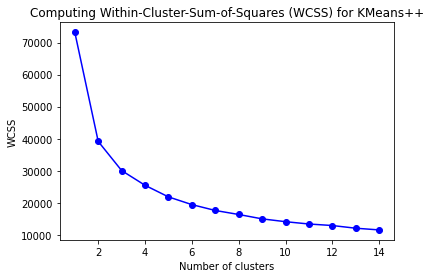

In [94]:
from sklearn.cluster import KMeans
# Use the Elbow method to find a good number of clusters using Within-Cluster-Sum-of-Squares (WCSS)
wcss = []
N = range(1, 15)
for i in N:
    kmeans = KMeans(n_clusters=i) 
    kmeans.fit_predict(df_std)
    wcss.append(kmeans.inertia_)
    
plt.plot(N, wcss, 'bo-')
plt.title("Computing Within-Cluster-Sum-of-Squares (WCSS) for KMeans++")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [95]:
#let's choose k = 4
cluster = KMeans(n_clusters=4)
df['cluster'] = cluster.fit_predict(df_std)

In [96]:
dfCluster = df.groupby('cluster', as_index=False).mean()
dfCluster['NO_CUST'] = df[['cluster','CUST_CODE']].groupby('cluster').count()

dfCluster

,cluster,TOTAL_SALES,TOTAL_VISIT,Recency,L_BASKET_SIZE,M_BASKET_SIZE,S_BASKET_SIZE,Full_Shop_BASKET_SIZE,Top_Up_BASKET_SIZE,Small_Shop_BASKET_SIZE,MM_BASKET_SIZE,LA_BASKET_SIZE,UM_BASKET_SIZE,NO_CUST
0,0,115.952070,10.403024,97.245711,2.889794,4.016284,3.496947,1.024135,2.788892,6.439372,5.780169,2.362896,2.004071,3439
1,1,3225.370566,311.405660,3.273585,88.830189,140.811321,81.764151,23.754717,101.688679,182.405660,148.292453,82.452830,76.113208,106
2,2,1606.102643,109.821586,8.392070,44.709251,38.458150,26.654185,18.596916,36.231278,53.903084,55.290749,30.885463,22.072687,454
3,3,14.761847,1.682056,547.473584,0.360781,0.569729,0.751547,0.120895,0.358877,1.179438,1.015707,0.318896,0.303665,2101


<Figure size 432x288 with 0 Axes>

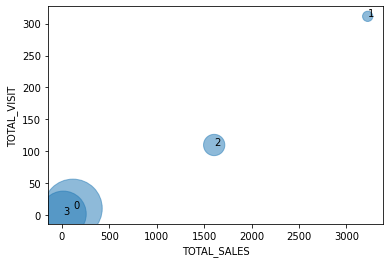

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
fig, ax = plt.subplots()
ax.scatter(dfCluster['TOTAL_SALES'], dfCluster['TOTAL_VISIT'], s=dfCluster['NO_CUST'], alpha = 0.5)
ax.set_xlabel("TOTAL_SALES")
ax.set_ylabel("TOTAL_VISIT")

for i, txt in enumerate(dfCluster['cluster']):
  ax.annotate(txt, (dfCluster['TOTAL_SALES'][i], dfCluster["TOTAL_VISIT"][i]))
plt.show()

<Figure size 432x288 with 0 Axes>

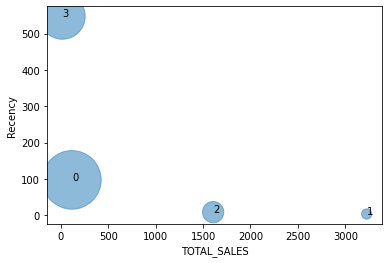

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure()
fig, ax = plt.subplots()
ax.scatter(dfCluster['TOTAL_SALES'], dfCluster['Recency'], s=dfCluster['NO_CUST'], alpha = 0.5)
ax.set_xlabel("TOTAL_SALES")
ax.set_ylabel("Recency")

for i, txt in enumerate(dfCluster['cluster']):
  ax.annotate(txt, (dfCluster['TOTAL_SALES'][i], dfCluster["Recency"][i]))
plt.show()

In [104]:
dfCluster

,cluster,TOTAL_SALES,TOTAL_VISIT,Recency,L_BASKET_SIZE,M_BASKET_SIZE,S_BASKET_SIZE,Full_Shop_BASKET_SIZE,Top_Up_BASKET_SIZE,Small_Shop_BASKET_SIZE,MM_BASKET_SIZE,LA_BASKET_SIZE,UM_BASKET_SIZE,NO_CUST
0,0,115.952070,10.403024,97.245711,2.889794,4.016284,3.496947,1.024135,2.788892,6.439372,5.780169,2.362896,2.004071,3439
1,1,3225.370566,311.405660,3.273585,88.830189,140.811321,81.764151,23.754717,101.688679,182.405660,148.292453,82.452830,76.113208,106
2,2,1606.102643,109.821586,8.392070,44.709251,38.458150,26.654185,18.596916,36.231278,53.903084,55.290749,30.885463,22.072687,454
3,3,14.761847,1.682056,547.473584,0.360781,0.569729,0.751547,0.120895,0.358877,1.179438,1.015707,0.318896,0.303665,2101


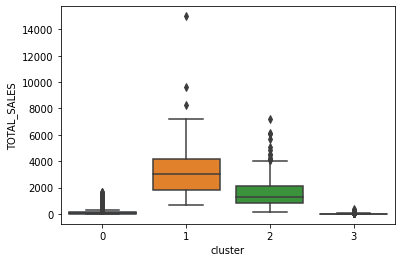

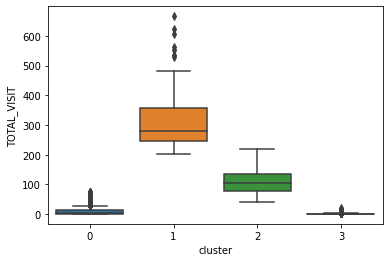

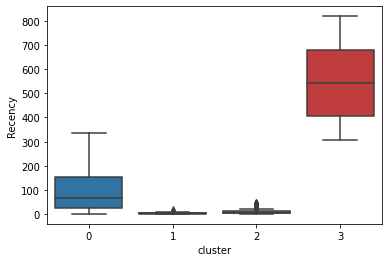

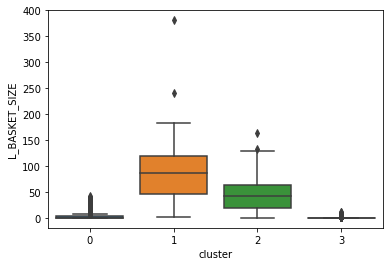

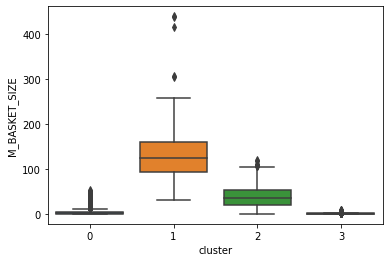

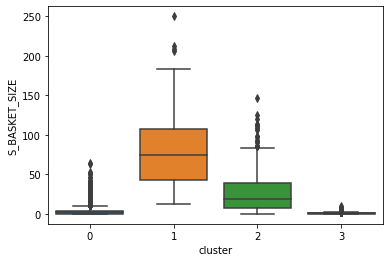

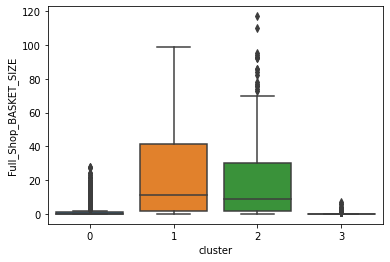

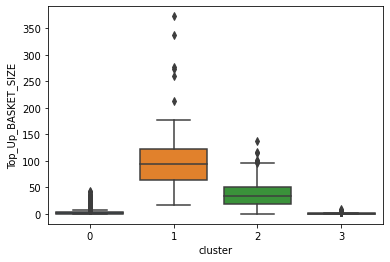

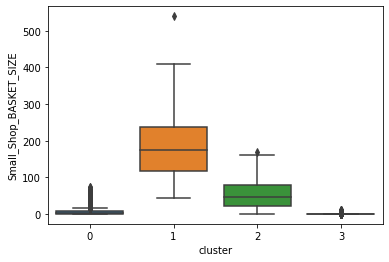

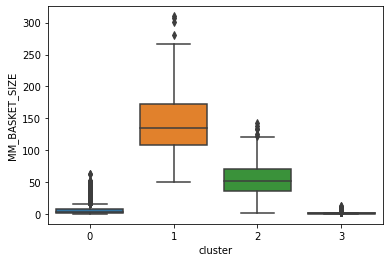

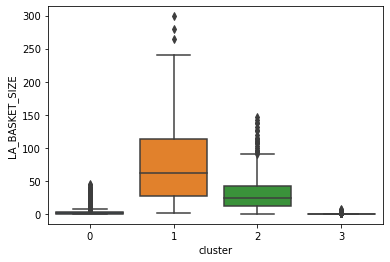

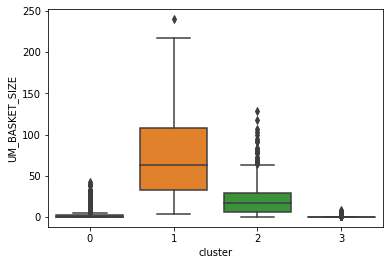

In [114]:
for i, col in enumerate(df.columns[1:-1]):
    sns.boxplot(x="cluster", y =col, data=df)
    plt.show()

In [115]:
from sklearn.ensemble import RandomForestClassifier

predictors = df.iloc[:,1:-1]
targets = df.iloc[:,-1:]

scaler = StandardScaler()
predictors_scaled = scaler.fit_transform(predictors)

classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
classifier.fit(predictors_scaled, targets.values.ravel())


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [116]:
importances = list(classifier.feature_importances_)

feature_list = list(predictors.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: Recency              Importance: 0.58
Variable: TOTAL_VISIT          Importance: 0.18
Variable: MM_BASKET_SIZE       Importance: 0.11
Variable: TOTAL_SALES          Importance: 0.02
Variable: L_BASKET_SIZE        Importance: 0.02
Variable: M_BASKET_SIZE        Importance: 0.02
Variable: Top_Up_BASKET_SIZE   Importance: 0.02
Variable: Small_Shop_BASKET_SIZE Importance: 0.02
Variable: S_BASKET_SIZE        Importance: 0.01
Variable: Full_Shop_BASKET_SIZE Importance: 0.01
Variable: LA_BASKET_SIZE       Importance: 0.01
Variable: UM_BASKET_SIZE       Importance: 0.01
